### Data Story - Demand Forescast Analysis

In [1]:
from IPython.display import HTML

In [2]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

### Introduction
The data for this exercise is from a supply-chain kaggle database. The purpose of this database is to use a forecasting algorithm to predict product demand.
The raw data can be found in the following link: https://www.kaggle.com/felixzhao/productdemandforecasting

### Data Wrangling
The first part of this code (hidden) cleans the data according to the data wrangling exercise.

In [3]:
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
fileloc = '/Users/arizeb/Desktop/SpringBoard - Data Science Bootcamp/Capstone Project/Historical Product Demand.csv'

In [5]:
data = pd.read_csv(fileloc)

In [6]:
data_backup = pd.read_csv(fileloc)

In [7]:
data['Date']=pd.to_datetime(data['Date'], format="%Y/%m/%d")

In [8]:
data['Order_Demand'] = data['Order_Demand'].replace('[\$)]','', regex=True).replace( '[(]','-', regex=True).astype(float)

In [9]:
data_notime = data_backup[(data['Date'].isnull())]

In [10]:
data=data.dropna()

#### Exploring values that are too small, too big and negative

In [11]:
data_pos=data[(data['Order_Demand']<1000000) & (data['Order_Demand'] > 0)]

There are three histograms that have been created in order to understand the distribution of the Order_Demand variable. The first was for values that are positive and lower than 1000000. There is no clear distribution here. However, we can see that just before 1000000 there are fewer values.

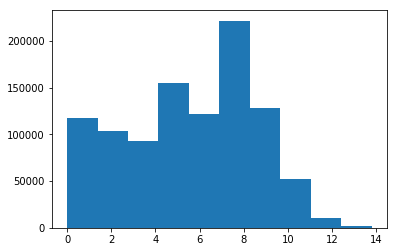

In [12]:
plt.hist(np.log(data_pos['Order_Demand']))
plt.show()

The following historgram show the distribution of values larger than 1000000. There are very few and these might be exceptions. None of these values were deleted.

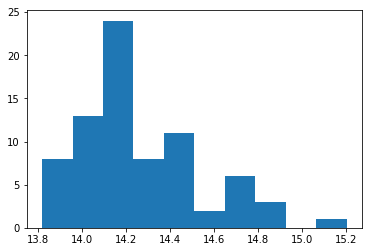

In [13]:
data_high=data[data['Order_Demand']>1000000]
plt.hist(np.log(data_high['Order_Demand']))
plt.show()

Finally, there were some values that were fewer than 0. Since demand cannot be negative these values were converted to 0. To understand the distribution of these values, a strip plot is presented below. From these values, we can see that a few categories concentrate the majority of the negative values: Category_019, for example

In [14]:
data_neg=data[data['Order_Demand']<0]

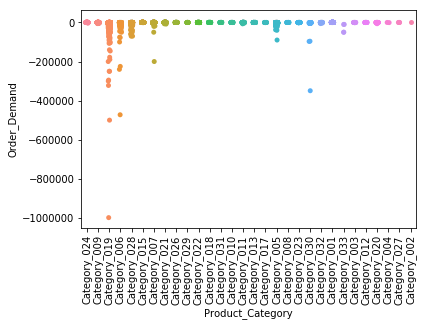

In [15]:
sns.stripplot(x='Product_Category', y='Order_Demand', data = data_neg,
             jitter = True)
plt.xticks(rotation=90)
plt.show()

In [16]:
data_temp = data['Order_Demand']
data_temp[data_temp<0] = 0
data['Order_Demand'] = data_temp

Following the above analysis, the number of data points per month has been plotted. As it can be seen in the graph bellow, 2011 and 2017 have very few values. Therefore, these years will not be considered for future analysis.

In [17]:
data_perDate = data.groupby(['Date'])['Order_Demand'].count()

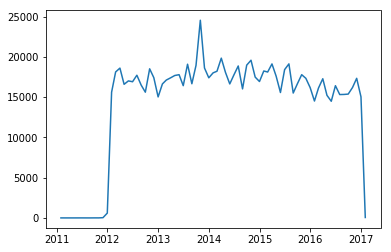

In [18]:
data_countpermonth = data_perDate.resample('m').sum()
plt.plot(data_countpermonth)
plt.show()

In [19]:
data = data.set_index('Date')

In [20]:
data = data.loc['2012':'2016']

### Summary Statistics
The table below show the key statistics for the data base. 
The company has 2160 products. 
The company manages 4 warehouses and there are 33 product categories. 
The data for the demand starts in 2012 and goes up to 2016.

In [21]:
data.reset_index().iloc[:,:4].describe()

,Date,Product_Code,Warehouse,Product_Category
count,1036643,1036643,1036643,1036643
unique,1681,2160,4,33
top,2013-09-27 00:00:00,Product_1359,Whse_J,Category_019
freq,2075,16935,764215,470090
first,2012-01-01 00:00:00,NaN,NaN,NaN
last,2016-12-30 00:00:00,NaN,NaN,NaN


In [22]:
data_countperMW = data.groupby([pd.Grouper(freq='M'),'Warehouse'])['Order_Demand'].count().reset_index()

### Warehouse Demand Analysis

An analysis of the number of orders per warehouse shows that Warehouse J and C have a range that does not change throughout the years. However, warehouse S and A experience changes during the years. In particular, WH A experiences a peak of demand around October 2013. On the other hand, WH S has experienced a drop in demand at the beginning of 2016.

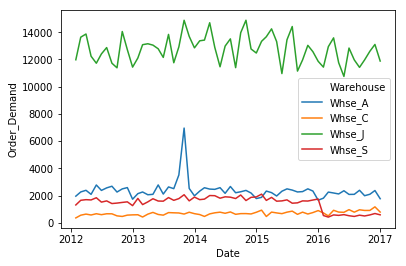

In [23]:
sns.lineplot(x='Date', y = 'Order_Demand', hue= 'Warehouse', 
            data=data_countperMW)
plt.show()

Although the number of orders has decreased for warehouse S, the the graph below we can see that the total quantity has not be reduced as drastically. All the other patterns remained stable as well.

In [24]:
data_sumperMW = data.groupby([pd.Grouper(freq='M'),'Warehouse'])['Order_Demand'].sum().reset_index()

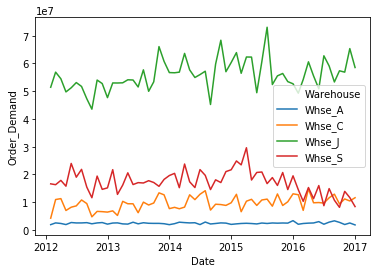

In [25]:
sns.lineplot(x='Date', y = 'Order_Demand', hue= 'Warehouse', 
            data=data_sumperMW)
plt.show()

To understand, the above phenomenon, we have graphed the monthly average size of each order and we can see that WH S has experience an increase in the size of orders which explains why the overall effect on the total amount of orders has not changed that much.

In [26]:
data_meanperMW = data.groupby([pd.Grouper(freq='M'),'Warehouse'])['Order_Demand'].mean().reset_index()

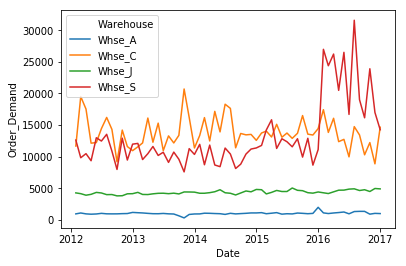

In [27]:
sns.lineplot(x='Date', y = 'Order_Demand', hue= 'Warehouse', 
            data=data_meanperMW)
plt.show()

#### Product order count vs order size
To understand better how the ordering at the warehouse level works, a graph that shows the average order size and the count of orders per product has been graphed for each warehouse.

From the graph below, it is clear that Warehouse J experience the highest pressure of the demand with the highest number of orders and the higher order sizes. Warehouse C, on the other hand, experiences the less pressure on the number of order and the order size.

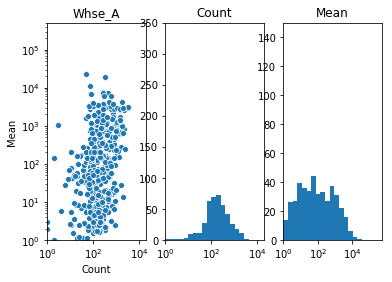

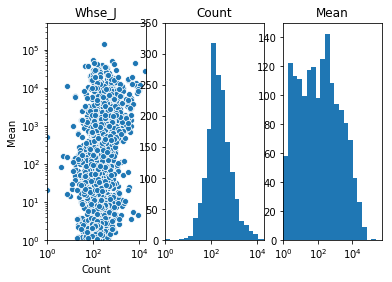

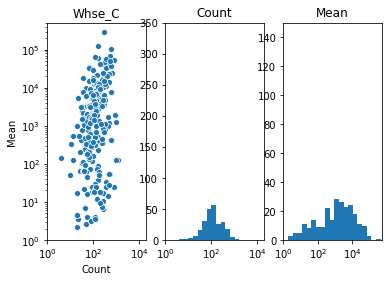

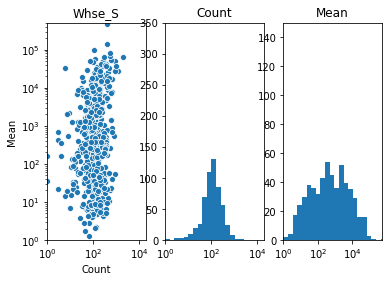

In [28]:
field = ['Product_Code','Warehouse']
data_scatter = pd.DataFrame()
data_scatter['Mean'] = data.groupby(field)['Order_Demand'].mean()
data_scatter['Count'] = data.groupby(field)['Order_Demand'].count()
for wh in data_scatter.reset_index().loc[:,'Warehouse'].unique():
    plt.subplot('131')
    pl = sns.scatterplot(x='Count', y='Mean', data = data_scatter.reset_index().set_index('Warehouse').loc[wh])
    pl.set(xscale='log', yscale='log')
    plt.title(wh)
    plt.xlim(1,max(data_scatter['Count'])*1.1)
    plt.ylim(1,max(data_scatter['Mean'])*1.1)
    
    plt.subplot('132')
    pl = plt.hist(data_scatter.reset_index().set_index('Warehouse').loc[wh,'Count'],
                 bins=np.logspace(np.log(1),np.log(max(data_scatter['Count'])*1.1), 50))
    plt.xscale('log')
    plt.title('Count')
    plt.xlim(1,max(data_scatter['Count'])*1.1)
    plt.ylim(0,350)
    
    plt.subplot('133')
    pl = plt.hist(data_scatter.reset_index().set_index('Warehouse').loc[wh,'Mean'],
                 bins=np.logspace(np.log(1),np.log(max(data_scatter['Mean'])*1.1), 50))
    plt.xscale('log')
    plt.title('Mean')
    plt.xlim(1,max(data_scatter['Mean'])*1.1)
    plt.ylim(0,150)
    
    plt.show()

### Product Categories
Having understood the demand patterns experienced by the warehouses and their differences, the analysis focuses now on product categories. The following scattered plot displays in logarithmic escale, the number of orders and the order size per categories. From this scatter plot, we learn tha the categoeries vary very widely on both variables. However there is a tendency to be concentrated towards the positive slope line that increases order size and order frequency. The few exeptions are Categories 025, 033 and 016.

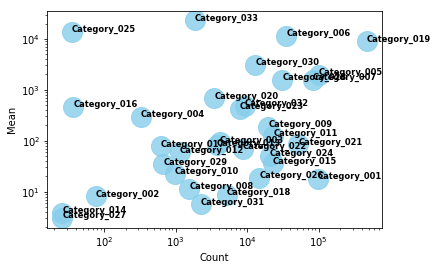

In [29]:
field = 'Product_Category'
data_scatter = pd.DataFrame()
data_scatter['Mean'] = data.groupby(field)['Order_Demand'].mean()
data_scatter['Count'] = data.groupby(field)['Order_Demand'].count()
pl = sns.regplot(x='Count', y='Mean', data = data_scatter.reset_index(), 
                 fit_reg=False, marker="o", color="skyblue", scatter_kws={'s':400})
pl.set(xscale='log', yscale='log')

for line in range(0,data_scatter.shape[0]):
     pl.text(data_scatter.Count[line]+0.2, data_scatter.Mean[line], 
             data_scatter.index[line], horizontalalignment='left', size='small', color='black', weight='semibold')

### Product Categories per quartile and their demand evolution
To understand better the demand per categories, they have been devided in 4 quartiles based on their total value.
The first 2 quartiles show demand evolution that show cyclical demand with similar level of variance.

The last 2 quartiles show a couple of product categories that have peak demands in 2015 and 2016 respectively. However, demand is also cyclical at this aggregated level.

In [30]:
data_sumperMC = data.groupby([pd.Grouper(freq='4M'),'Product_Category'])['Order_Demand'].sum().reset_index()

In [31]:
data_categorytotal = data_sumperMC.groupby('Product_Category').sum().sort_values(by='Order_Demand',ascending=False)
index_above75 = data_categorytotal.iloc[1:round(len(data_categorytotal)/4),:].index
index_above50 = data_categorytotal.iloc[round(len(data_categorytotal)/4):round(len(data_categorytotal)*2/4),:].index
index_above25 = data_categorytotal.iloc[round(len(data_categorytotal)*2/4):round(len(data_categorytotal)*3/4),:].index
index_above00 = data_categorytotal.iloc[round(len(data_categorytotal)*3/4):,:].index

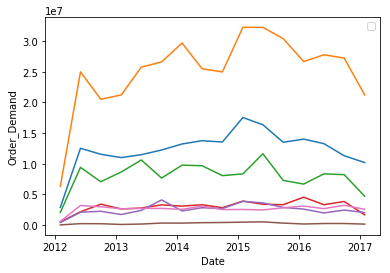

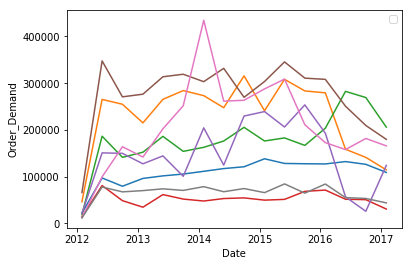

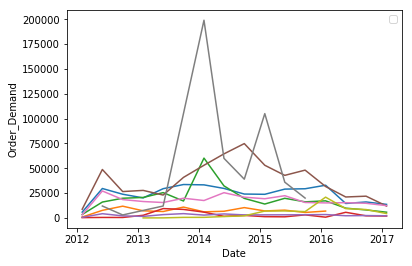

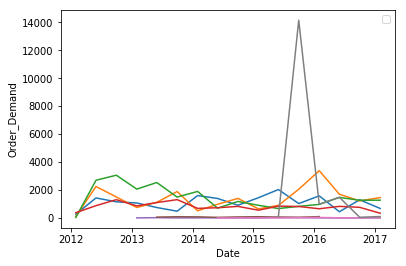

In [32]:
sns.lineplot(x='Date', y = 'Order_Demand', hue= 'Product_Category', 
            data=data_sumperMC[data_sumperMC['Product_Category'].isin(index_above75)])
plt.legend([])
plt.show()

sns.lineplot(x='Date', y = 'Order_Demand', hue= 'Product_Category', 
            data=data_sumperMC[data_sumperMC['Product_Category'].isin(index_above50)])
plt.legend([])
plt.show()

sns.lineplot(x='Date', y = 'Order_Demand', hue= 'Product_Category', 
            data=data_sumperMC[data_sumperMC['Product_Category'].isin(index_above25)])
plt.legend([])
plt.show()

sns.lineplot(x='Date', y = 'Order_Demand', hue= 'Product_Category', 
            data=data_sumperMC[data_sumperMC['Product_Category'].isin(index_above00)])
plt.legend([])
plt.show()

### Demand pattern in the last 3 years
To understand the demand pattern, the last 3 years have been graphed in separated scatter plots showing the order size, the order frequency and their respective distribution. The distributions are very similar throughout the 3 years.

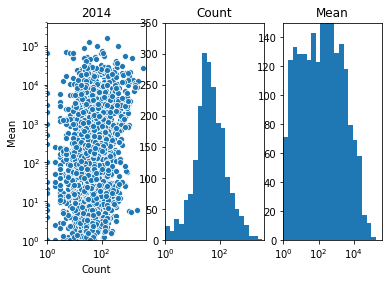

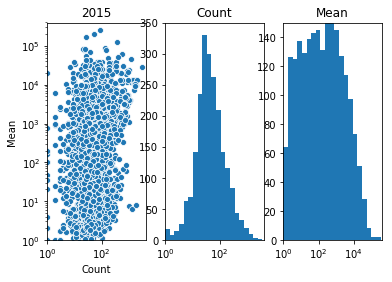

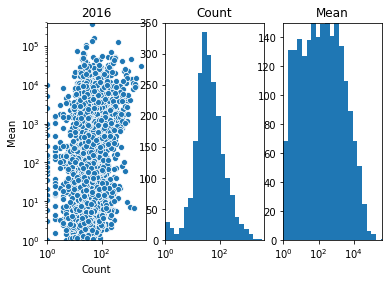

In [33]:
field = 'Product_Code'
data_scatter = pd.DataFrame()
data_scatter['Mean'] = data.groupby([pd.Grouper(freq='Y'),field])['Order_Demand'].mean()
data_scatter['Count'] = data.groupby([pd.Grouper(freq='Y'),field])['Order_Demand'].count()
for yr in ['2014','2015','2016']:
    plt.subplot('131')
    pl = sns.scatterplot(x='Count', y='Mean', data = data_scatter.reset_index().set_index('Date').loc[yr])
    pl.set(xscale='log', yscale='log')
    plt.title(yr)
    plt.xlim(1,max(data_scatter['Count'])*1.1)
    plt.ylim(1,max(data_scatter['Mean'])*1.1)
    
    plt.subplot('132')
    pl = plt.hist(data_scatter.reset_index().set_index('Date').loc[yr,'Count'],
                 bins=np.logspace(np.log(1),np.log(max(data_scatter['Count'])*1.1), 50))
    plt.xscale('log')
    plt.title('Count')
    plt.xlim(1,max(data_scatter['Count'])*1.1)
    plt.ylim(0,350)
    
    plt.subplot('133')
    pl = plt.hist(data_scatter.reset_index().set_index('Date').loc[yr,'Mean'],
                 bins=np.logspace(np.log(1),np.log(max(data_scatter['Mean'])*1.1), 50))
    plt.xscale('log')
    plt.title('Mean')
    plt.xlim(1,max(data_scatter['Mean'])*1.1)
    plt.ylim(0,150)
    
    plt.show()

### Product Life Cycle
A last important aspect in this analysis, is to show the product life cycle of products. Products in general tend to have a phase of demand growth, demand stability and demand decrease. To understand if this is the case in the products of this company, 5 random products has been selected. In order to compare the demand patterns, we have graphed the ratio with respect to the highest demand for each product. What we observe is that for 3 products the typical life cycle trend can be observered. Demand increased from 2012 to the middle of 2015 and then demand has decreased. This cannot be said to be the rule for all products but provides an insight to understand demand overall behavior.

In [34]:
data_sumperMP = data.groupby([pd.Grouper(freq='6M'),'Product_Code'])['Order_Demand'].sum().reset_index()

In [35]:
data_maxperProduct = data_sumperMP.groupby('Product_Code')['Order_Demand'].max().reset_index()

In [36]:
data_lifecycle = pd.merge(data_sumperMP, data_maxperProduct, on='Product_Code')

In [37]:
data_lifecycle['Ratio']= data_lifecycle['Order_Demand_x']/data_lifecycle['Order_Demand_y']

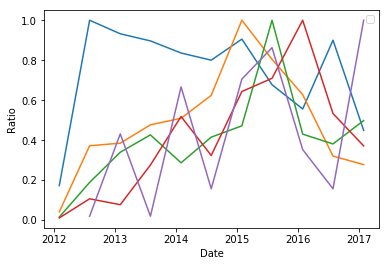

In [38]:
sns.lineplot(x='Date', y = 'Ratio', 
             hue = 'Product_Code', 
             data = data_lifecycle.loc[data_lifecycle['Product_Code'].str[-4:]<='0005'])
plt.legend([])
plt.show()